In [1]:
from IPython.core.display import display, HTML, Markdown
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy as np
import random
import numpy.random as rd
import matplotlib.pyplot as plt

import import_ipynb
import sys
#import boris_stepper
from Functions import push_particles

import pandas as pd
from pandas import Series, DataFrame
from scipy.optimize import curve_fit 

%matplotlib inline
%matplotlib notebook

importing Jupyter notebook from Functions.ipynb


In [3]:
path_in = 'C:\\Users\\mathe\\OneDrive\\Área de Trabalho\\Monte Carlo\\23102023\\Evento07102015\\'

* ### Constantes

In [4]:
c      = 299792458  # velocidade da luz em m/s
dt     = 1e-2       # passo temporal em segundos.
Nsteps = 1400       # número de passos temporais. 2000
skip   = 1          # Taxa de pulos no dados salvos.

t=np.zeros(int(Nsteps/skip)+1)
t[0] = 0.0  

In [8]:
# Definição dos parâmetros relevantes para o inicio da simulação.

# Carga da partícula. +1 para próton, e -1 para elétron
q =  1.0
qe = 1.60217662e-19 # carga elementar.

# Massa da partícula em função da massa do elétron
m = 1.836e3
me= 9.10938356e-31 # massa do elétron em kg.

# rest mass energy in eV
# magnetic permeability of vacuum.
muo=4*np.pi*1e-7

# Razão dos calores específicos ratio of specific heats
gamma= 2

# Parâmetros físicos pré-choques obtidos no evento do dia 01/12/2-15
B = 16.00     # nT
n = 21.27     # cm^-3
T = 4.62*1e5 # K

n1  = n*1e6                                             # particle number density in #/m^3
T1  = T/11604 # em eV                                   # ion temperature in eV. Electron temperature assumed to be the same.
B1  = B*1e-9                                            # magnetic field strength in Tesla.

B1u = np.array([0,0,B1])
v1  = 422.97*1e3      # km/s  4.95e5                       # drifting speed in m/s

# derived parameters
Eu = -np.cross(np.array([0,v1,0]),B1u)                  # electric field. The same on both sides.
p1 = 2*n1*1.3806e-23*(T1*1.1604e4)                      # thermal pressure in Pa (the "2" comes from p = pi + pe = n1*k_B*(Ti+Te)=2*n1*k_B*T1).
rho1 = n1*(m*me)                                        # particle mass density in kg/m^3.
R1 = np.sqrt(p1/rho1)*(m*me)/((np.abs(q)*1.602e-19)*B1) # thermal gyroradius in m.

## Carregamento dos dados 

In [ ]:
vxi = np.loadtxt(path_in+'Vx_MB.txt'); v_d = np.loadtxt(path_in+'Vy_MB.txt'); vzi = np.loadtxt(path_in+'Vz_MB.txt'); n = np.loadtxt(path_in+'n.txt')

# Simulação boris 2 D

In [ ]:
# ------------------------------------------------------
# Loop over the "npart" particles.
# ------------------------------------------------------
# Boundaries of the simulation box in the X-direction. 

x0lower = -5.0
x0upper = 5.0 

# Geração das posições em x
x = x0lower+rd.random(len(v_d))*(x0upper-x0lower)

rx = np.zeros([int(Nsteps/skip)+1,len(v_d)]); ry = np.zeros([int(Nsteps/skip)+1,len(v_d)]); rz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
vx = np.zeros([int(Nsteps/skip)+1,len(v_d)]); vy = np.zeros([int(Nsteps/skip)+1,len(v_d)]); vz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
ek = np.zeros([int(Nsteps/skip)+1,len(v_d)]); mu = np.zeros([int(Nsteps/skip)+1,len(v_d)]); rL = np.zeros([int(Nsteps/skip)+1,len(v_d)])

for i in range(len(v_d)):
    
    x0 = x[i]*R1
    y0 = -4.0*R1 
    z0 = 0.0
    
    r0  = np.array([x0, y0, z0])
    r   = r0
    
    vx0 = vxi[i]
    vy0 = v_d[i]
    v   = np.array([vx0,vy0,0])

    v1std = np.linalg.norm(v)
    
    em = 0.5*(rho1*(v1std**2)+B1**2/(muo))+p1
    
    zeta = ( (2*gamma*em-rho1*(v1std**2))+ np.sqrt((2*gamma*em-rho1*(v1std**2))**2 - 4*rho1*(gamma+1)*(gamma-2)*(v1std*B1)**2/muo ) )/(2*rho1*(gamma+1)*v1std**2)  
    
    # Lorentz's factor
    gammaL = 1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
    
    # particle velocity with factor gamma
    u = np.array([gammaL*v[0], gammaL*v[1], gammaL*v[2]])
    rx[0,i]=r0[0];  ry[0,i]=r0[1];  rz[0,i]=r0[2]
    vx[0,i]=v[0];   vy[0,i]=v[1];   vz[0,i]=v[2]
    ek[0,i]=gammaL-1 
    mu[0,i]=(gammaL-1)/(np.linalg.norm(B1u))
    rL[0,i]=(m*me)*np.linalg.norm(v1std)/(np.abs(q*qe)*(np.linalg.norm(B1u)))
    
    counter=0
    efield = Eu         
    for it in range(Nsteps):
        if r[1] < 0.:
            bfield = B1u
        else:
            bfield = B1u/zeta
            
            v[0]=v[0]*zeta
            v[1]=v[1]*zeta
            v[2]=v[2]*zeta                                           
                                      
        r,v = push_particles(qe,m*me,dt,c,efield,bfield,u,r,v)
        #r,v = boris_stepper.push_particles(q,m,dt,c,efield,bfield,u,r,v)
        
        # apply periodic boundary conditions along x-direction for the special case of a symmetric interval. 
        # left boundary condition
        if r[0] < x0lower*R1: r[0] = r[0] + (np.abs(x0upper)+np.abs(x0lower))*R1
        # right boundary condition
        if r[0] > x0upper*R1: r[0] = r[0] - (np.abs(x0upper)+np.abs(x0lower))*R1
        
        if np.mod(it,skip) == 0:
            
            rx[counter+1,i]=r[0]; ry[counter+1,i]=r[1]; rz[counter+1,i]=r[2] 
            vx[counter+1,i]=v[0]; vy[counter+1,i]=v[1]; vz[counter+1,i]=v[2]
            gammaL=1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
            ek[counter+1,i]= gammaL-1
            mu[counter+1,i]=(gammaL-1)/np.linalg.norm(bfield)
            
            #vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-np.square(np.dot(v,bfield)/np.linalg.norm(bfield)))
            vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-(np.dot(v,bfield)/np.linalg.norm(bfield))**2)
            
            rL[counter+1,i]=(m*me)*vperp/(np.abs(q*qe)*(np.linalg.norm(bfield))) # Larmor radius
            t[counter+1]=t[counter]+dt*skip
            counter=counter+1

## Salvamento (primeira iteração)

In [ ]:
#C:\Users\mathe\OneDrive\Área de Trabalho\Monte Carlo\23102023\Simulação eventos\2D

np.savetxt(path_in+'2D\\'+'rx_skp1.txt', rx); np.savetxt(path_in+'2D\\'+'ry_skp1.txt', ry)  
np.savetxt(path_in+'2D\\'+'vx_skp1.txt', vx); np.savetxt(path_in+'2D\\'+'vy_skp1.txt', vy) 
np.savetxt(path_in+'2D\\'+'ek_skp1.txt', ek); np.savetxt(path_in+'2D\\'+'mu_skp1.txt', mu) ; np.savetxt(path_in+'2D\\'+'rL_skp1.txt', rL)

##  Carregamento

In [5]:
rx = np.loadtxt(path_in+'2D\\'+'rx_skp1.txt'); ry = np.loadtxt(path_in+'2D\\'+'ry_skp1.txt') 
vx = np.loadtxt(path_in+'2D\\'+'vx_skp1.txt'); vy = np.loadtxt(path_in+'2D\\'+'vy_skp1.txt') 
ek = np.loadtxt(path_in+'2D\\'+'ek_skp1.txt'); mu = np.loadtxt(path_in+'2D\\'+'mu_skp1.txt') ; rL = np.loadtxt(path_in+'2D\\'+'mu_skp1.txt')

## Gráficos 

In [6]:
y_p = 5.1526656924467975

<IPython.core.display.Javascript object>


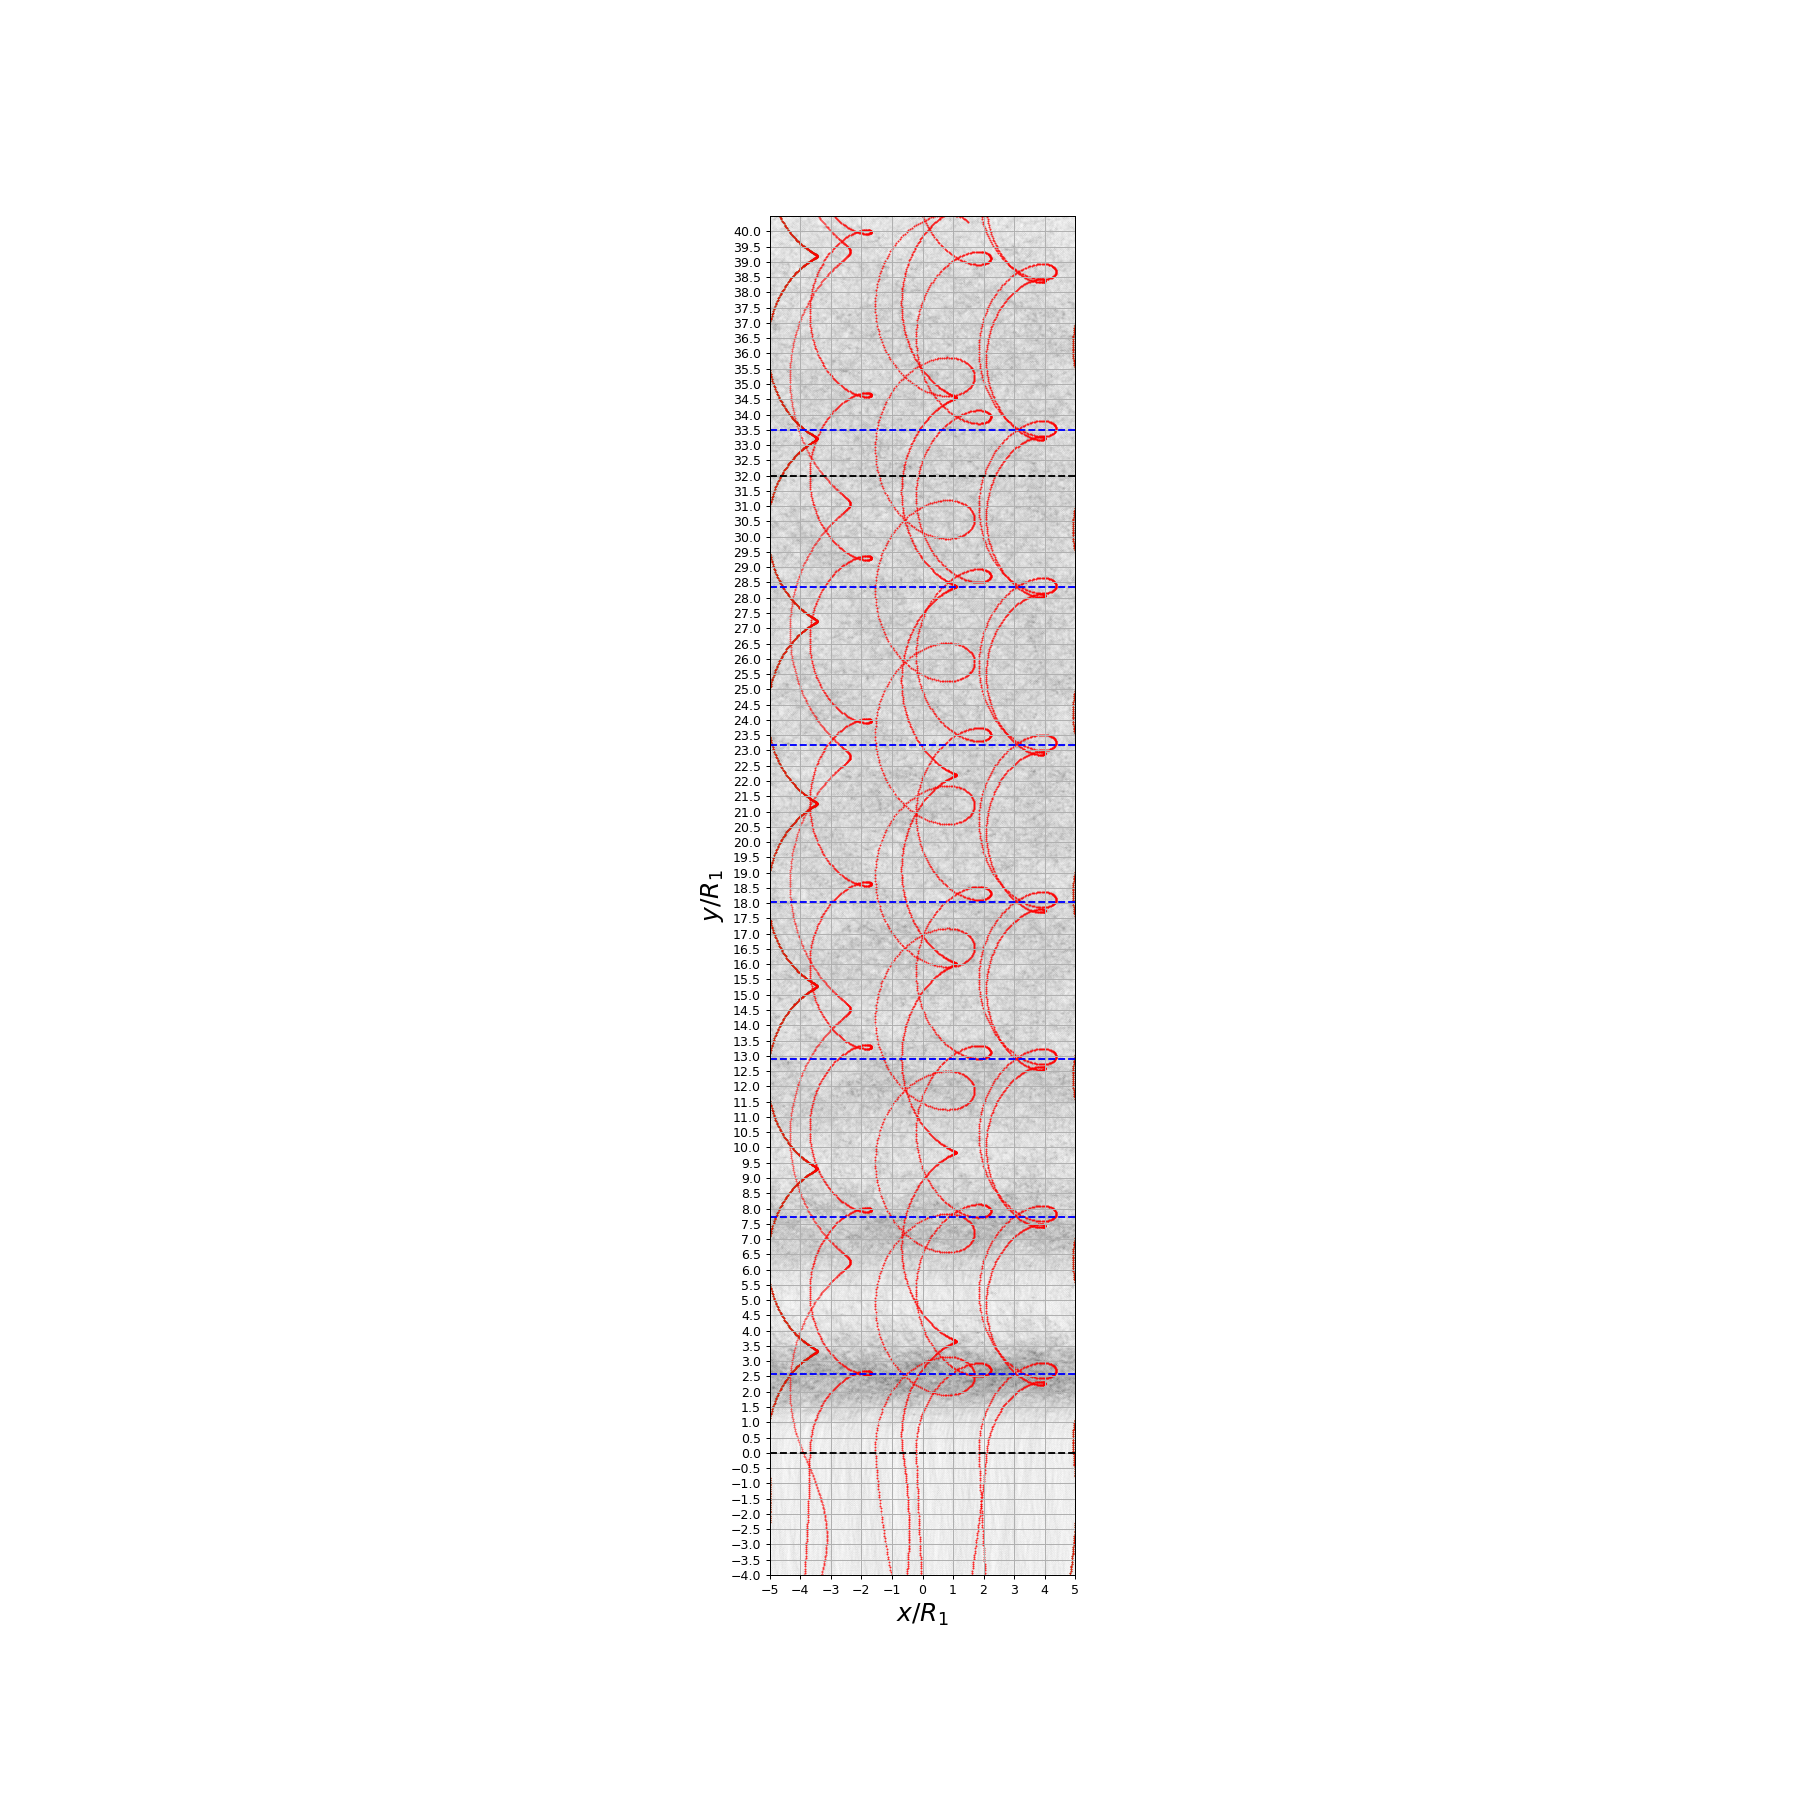

In [9]:
ynlim = 1800
y0 = -4.0*R1 

fig,ax = plt.subplots(1,1,figsize=(20,20))

ax.scatter(rx[:ynlim,0:50000:20]/R1,ry[:ynlim,0:50000:20]/R1,s=0.00002, color='k')

ax.scatter(rx[:ynlim,10]/R1  , ry[:ynlim,10]/R1,s=0.5,marker='.', color='r')
ax.scatter(rx[:ynlim,1200]/R1, ry[:ynlim,1200]/R1,s=0.5,marker='.', color='g')

#ax.plot(x0/R1,y0/R1,'sk',markersize=12,markerfacecolor='none', markeredgecolor='black')

for i in range(0,7):
    
    ax.axhline(y= (1/2+i)*y_p, color='blue', linestyle='--')
    ax.scatter(rx[:ynlim,200*i]/R1  , ry[:ynlim,200*i]/R1,s= 1 ,marker='.', color='r')
    
# Limites da região de separação entre as regiões (y=0) e final da região pós-choque (y=32)

ax.axhline(y=0.0, color='k', linestyle='--')
ax.axhline(y=32., color='k', linestyle='--')

ax.set_ylim([-4,40.5]);  #[y0/R1,100.5]
ax.set_xlim([-5,5])

ax.set_xticks(np.arange(-5,5.1,1))

ax.set_yticks(np.arange(-4,40.1,0.5))

ax.set_xlabel(r'$x/R_1$',size=20);ax.set_ylabel(r'$y/R_1$',size= 20)
ax.grid(axis='both')

ax.set_aspect(1)

#plt.savefig(path_in+'2D\\plot_01.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

## Discretização 

In [10]:
R1

56986.011133990025

In [11]:
# Ajuste do tamanho dos vetores posição (rx e ry) para realizar a descritização dentro de uma faixa especifica.
rx_d = rx[:ynlim,:]; ry_d = ry[:ynlim,:]

rx_d.shape, ry_d.shape

((1401, 50000), (1401, 50000))

In [ ]:
# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10

# Limites em x e y x0lower = -5.0 x0upper = 5.0   
x_1 = -5 ;  y_1 = -4
x_2 =  5 ;  y_2 = 32
 
# Definição das regiões pré-choque e pós-choque
i_up = int((0-y_1)/dy)          #Construção dos indices para os vetores
i_dw = int((y_2-y_1)/dy)

# Discretização 
x_i = int((x_2-x_1)/dx)
y_i = int((y_2-y_1)/dy)

rx_d = rx/R1; ry_d = ry/R1
    
#Cálculo das densidades numéricas    
cc   = np.zeros((x_i, y_i))
c_vx = np.zeros((x_i, y_i))
c_vy = np.zeros((x_i, y_i))

x_size = np.arange(len(rx_d))
y_size = np.arange(len(rx_d[0,:]))

x_ii = np.arange(x_1, x_2, dx)
y_jj = np.arange(y_1, y_2, dy)

for i in x_size:
    
    for j in y_size:
        
        for k in x_ii:
            
            if k <rx_d[i,j]< k + dx:
                
                for l in y_jj:
                    
                    if l < ry_d[i,j] < l+dy:
                        
                        cc[round((k-x_1)/dx),   round((l-y_1)/dy)]  += 1
                        c_vx[round((k-x_1)/dx), round((l-y_1)/dx)]  += vx[i,j]
                        c_vy[round((k-x_1)/dy), round((l-y_1)/dy)]  += vy[i,j]
                        
                        break
                break
                
cm_vx = c_vx/cc; cm_vy = c_vy/cc  # Valores médios
cc_n = cc/np.max(cc)  
    
#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2)

w_i = (n1*v1)/((cc*cm_v)/(dx*R1*dy*R1))  
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1)
    
aa = np.mean(Z_d[:][0:i_up])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vy.T 

### Salvamento 

In [ ]:
#path_in+'boris2D\\Extensao\\ ; path_in+'boris2D\\'+'cc_01.txt'
#path_in+'boris2D\\Extensao_100

np.savetxt(path_in+'2D\\'+'cc_skp1_32.txt', cc); 
np.savetxt(path_in+'2D\\'+'w_i_skp1_32.txt', w_i) 
np.savetxt(path_in+'2D\\'+'cvx_skp1_32.txt', cm_vx)
np.savetxt(path_in+'2D\\'+'cvy_skp1_32.txt', cm_vy)

### Carregamento 

In [90]:
cc    = np.loadtxt(path_in+'2D\\'+'cc_skp1_32.txt')
w_i   = np.loadtxt(path_in+'2D\\'+'w_i_skp1_32.txt') 
cm_vx = np.loadtxt(path_in+'2D\\'+'cvx_skp1_32.txt')
cm_vy = np.loadtxt(path_in+'2D\\'+'cvy_skp1_32.txt')

# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10

# Limites em x e y x0lower = -5.0 x0upper = 5.0 
x_1 = -5 ;  y_1 = -4
x_2 =  5 ;  y_2 = 32     
 
# Definição das regiões pré-choque e pós-choque
i_up = int((0-y_1)/dy)          #Construção dos indices para os vetores
i_dw = int((y_2-y_1)/dy)

#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2)
cc_n = cc/np.max(cc) 
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1)
    
aa = np.mean(Z_d[:][0:i_up+1])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up+1:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vy.T 

# Contas

In [91]:
f11 = np.mean(F_X[:][0:i_up])/1e11
f12 = np.mean(F_X[:][i_up:])/1e11 

f21 = np.mean(F_Y[:][0:i_up])/1e11
f22 = np.mean(F_Y[:][i_up:])/1e11 

F_1 = np.sqrt(f11**2+f21**2)
F_2 = np.sqrt(f12**2+f22**2)

n_1 = (aa*1e6)
n_2 = (bb*1e6)

v_1 = (F_1*1e11)/n_1 
v_2 = (F_2*1e11)/n_2

np.shape(F_X[:][0:i_up]), np.shape(F_X[:][i_up:i_dw]), f11, f12, f21, f22, v_1, v_2, aa, bb/aa

((40, 100),
 (320, 100),
 -0.7890142534590829,
 0.5723813974886696,
 89.9589208311,
 89.5785551555254,
 414844.64628808235,
 174765.73003388583,
 21.685800148033515,
 2.36363924554895)

In [92]:
Fx = pd.DataFrame(F_X,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
Fy = pd.DataFrame(F_Y,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))

Fx = Fx.T/1e11
Fy = Fy.T/1e11

Fx

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,31.05,31.15,31.25,31.35,31.45,31.55,31.65,31.75,31.85,31.95
-4.95,1.387214,1.206726,1.410401,0.431819,-0.000998,0.191280,0.118190,-0.401292,-1.058461,-1.257515,...,-0.280693,-3.057201,-2.050024,-2.658678,3.638048,2.787569,-1.819638,0.970229,6.055140,1.933087
-4.85,0.291942,-0.059768,0.624528,1.160250,0.818600,0.247406,-0.012285,0.807795,0.721877,0.819046,...,-4.439634,0.412446,-3.263704,-1.964598,5.603247,0.127364,-1.358312,4.550367,0.587661,1.340923
-4.75,0.175039,0.095556,-0.694685,-0.562160,-0.719799,0.279963,0.212185,-0.025082,0.292019,-0.064268,...,-9.085714,-2.837070,-0.468051,-1.073666,0.671686,1.887359,4.298920,2.186328,-0.384065,3.626585
-4.65,0.514449,0.400519,0.321651,-0.702258,-0.752187,-1.321624,-1.093425,-0.564224,-0.533439,-0.320952,...,3.032600,-3.702621,-3.647532,0.078417,-2.052826,-0.665260,4.136515,3.632213,-0.456737,0.919087
-4.55,-0.117799,-0.500143,-0.679096,0.421741,-0.254935,0.336517,-0.843183,-0.476009,-0.551317,-0.983516,...,1.549578,-2.704419,1.359534,0.967507,-5.135188,-3.202120,2.343789,1.880301,0.655698,3.872634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,0.155070,-0.227378,0.456594,-0.081623,0.242785,-0.014441,-0.363213,-0.233714,-0.819579,-0.788176,...,1.409560,-0.269099,2.923091,1.745602,-3.133517,-2.472755,-0.177185,-2.372830,-1.554523,0.007370
4.65,-0.390186,-0.277720,0.000766,-0.433079,-0.470034,-0.652698,-1.115390,-1.408037,-1.173003,-0.934337,...,2.480820,1.906265,1.007135,-0.182370,-2.955961,0.121222,0.052501,-5.916471,1.548310,2.064904
4.75,0.542172,-0.133911,-0.873178,-1.208718,-1.316662,-0.870571,-0.266318,0.149659,0.051266,-0.221789,...,-0.907464,1.147308,0.870436,-0.305310,-1.898208,-3.321386,-1.890138,0.944757,-1.528441,9.043733
4.85,-1.083397,-0.737214,0.198051,0.553174,0.398262,0.370208,-0.262117,-0.632527,-0.389527,-0.849394,...,-6.126402,-6.266812,-0.581613,1.027686,3.237381,-5.695943,1.387553,-0.313389,-3.375174,5.262461


In [93]:
Fy

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,31.05,31.15,31.25,31.35,31.45,31.55,31.65,31.75,31.85,31.95
-4.95,89.955023,89.957626,89.954663,89.964683,89.965719,89.965516,89.965641,89.964824,89.959492,89.956930,...,89.965281,89.913759,89.942359,89.926426,89.892131,89.922523,89.947315,89.960487,89.761717,89.944949
-4.85,89.965245,89.965699,89.963551,89.958237,89.961995,89.965379,89.965718,89.962092,89.962823,89.961991,...,89.856109,89.964774,89.906501,89.944266,89.791059,89.965629,89.955464,89.850569,89.963800,89.955725
-4.75,89.965549,89.965668,89.963037,89.963963,89.962839,89.965283,89.965469,89.965716,89.965245,89.965696,...,89.505756,89.920974,89.964501,89.959312,89.963212,89.945920,89.862951,89.939149,89.964899,89.892594
-4.65,89.964248,89.964827,89.965144,89.962978,89.962574,89.956011,89.959074,89.963950,89.964138,89.965147,...,89.914592,89.889494,89.891747,89.965685,89.942295,89.963259,89.870573,89.892367,89.964560,89.961024
-4.55,89.965642,89.964329,89.963156,89.964730,89.965358,89.965090,89.961768,89.964460,89.964030,89.960343,...,89.952373,89.925062,89.955446,89.960516,89.819043,89.908715,89.935184,89.946068,89.963330,89.882330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,89.965585,89.965432,89.964560,89.965682,89.965391,89.965718,89.964986,89.965415,89.961986,89.962266,...,89.954676,89.965317,89.918219,89.948782,89.911132,89.931730,89.965545,89.934422,89.952288,89.965719
4.65,89.964873,89.965290,89.965719,89.964677,89.964491,89.963351,89.958804,89.954700,89.958072,89.960867,...,89.931508,89.945521,89.960082,89.965534,89.917145,89.965637,89.965704,89.770964,89.952395,89.942019
4.75,89.964085,89.965619,89.961482,89.957599,89.956084,89.961507,89.965325,89.965595,89.965704,89.965446,...,89.961142,89.958403,89.961508,89.965201,89.945691,89.904388,89.945861,89.960758,89.952735,89.510008
4.85,89.959195,89.962698,89.965501,89.964018,89.964837,89.964957,89.965337,89.963495,89.964876,89.961709,...,89.756882,89.747187,89.963839,89.959849,89.907452,89.785226,89.955018,89.965173,89.902385,89.811676


<IPython.core.display.Javascript object>


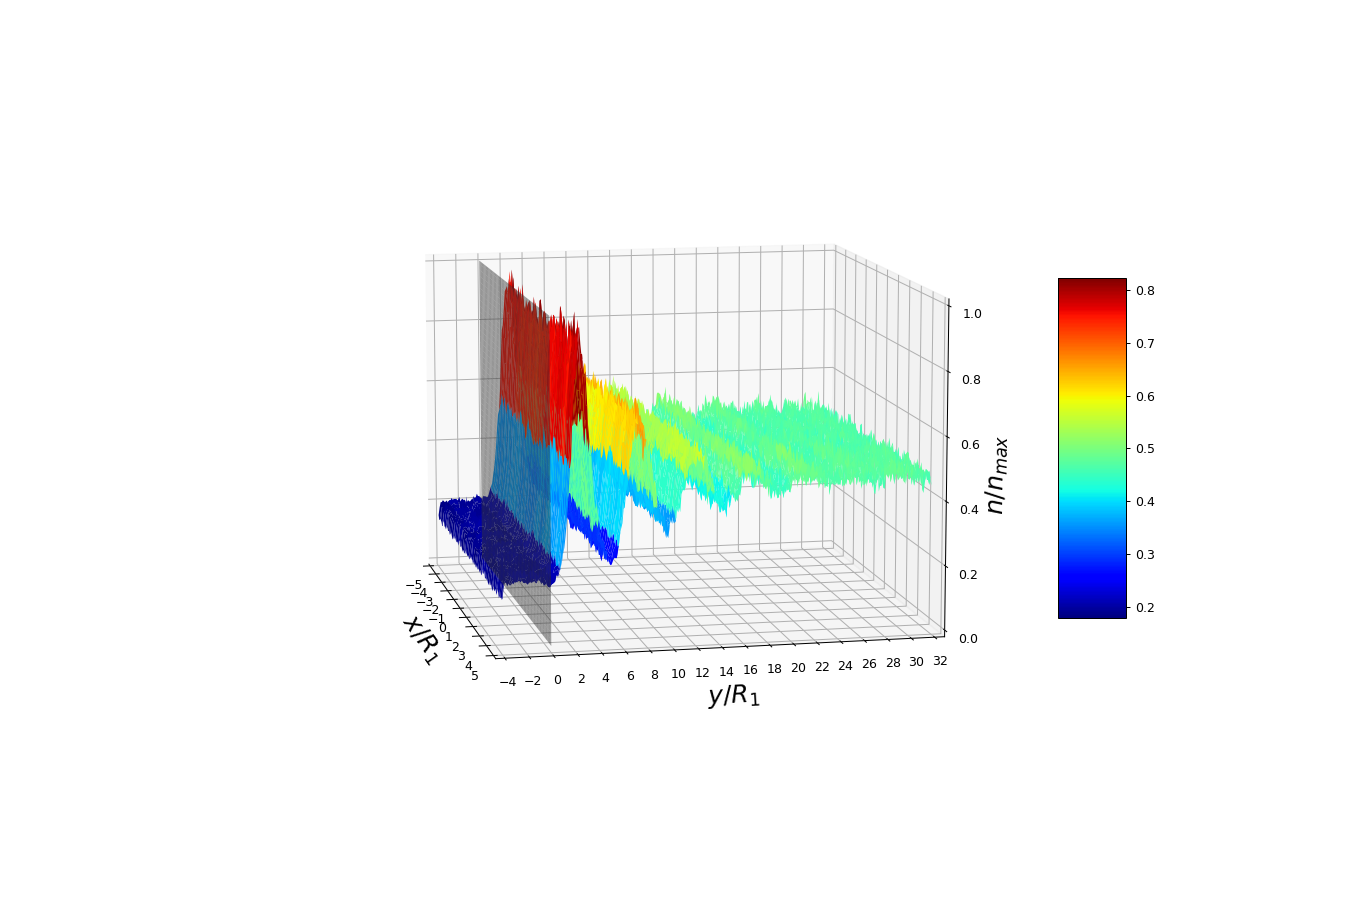

In [94]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(15,10))

# Make data.

X = np.arange(-5+dx/2,5,dx)
Y = np.arange(-4+dy/2,32.,dy)

X, Y = np.meshgrid(X, Y)

Z = cc_n.T   #Usando transposta


# Plot the surface.
surf = ax.plot_surface(X, Y, Z , cmap='jet')

z_p, x_p = np.meshgrid(np.linspace(0,1,100),np.linspace(-5,5, 100))

y_p = x_p*0

ax.plot_surface(x_p, y_p, z_p, color= "gray", alpha=0.5)  # the vertical plane

ax.set_xlabel(r'$x/R_1$',size=20)
ax.set_ylabel(r'$y/R_1$',size=20, labelpad=10)
ax.set_zlabel(r'$n/n_{max}$',size=20)

ax.set_xlim([-4.9,5.1])
ax.set_ylim([-3.9,32.1])

ax.set_xticks(np.arange(-5,5.1,1))
ax.set_yticks(np.arange(-4,32.1,2))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(10, -12)

#plt.savefig(path_in+'boris2D\\Extensao\\Densidade númerica_50000_particles_01.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

### Estimativa dos erros

In [95]:
cc_td =  pd.DataFrame(cc,  index =np.arange(x_1+dx/2,x_2,dx) , columns = np.arange(y_1+dy/2,y_2,dy))
cc_td

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,31.05,31.15,31.25,31.35,31.45,31.55,31.65,31.75,31.85,31.95
-4.95,528.0,617.0,679.0,680.0,694.0,688.0,676.0,685.0,676.0,667.0,...,1636.0,1633.0,1582.0,1587.0,1600.0,1626.0,1657.0,1675.0,1616.0,1596.0
-4.85,483.0,635.0,720.0,728.0,715.0,687.0,706.0,725.0,673.0,674.0,...,1634.0,1628.0,1568.0,1544.0,1571.0,1596.0,1715.0,1557.0,1724.0,1656.0
-4.75,487.0,580.0,640.0,640.0,666.0,670.0,667.0,696.0,703.0,715.0,...,1604.0,1739.0,1520.0,1428.0,1544.0,1500.0,1678.0,1580.0,1572.0,1573.0
-4.65,515.0,622.0,711.0,681.0,696.0,686.0,678.0,671.0,684.0,688.0,...,1692.0,1547.0,1598.0,1477.0,1564.0,1714.0,1677.0,1577.0,1678.0,1625.0
-4.55,500.0,630.0,740.0,702.0,700.0,732.0,704.0,713.0,691.0,671.0,...,1691.0,1565.0,1525.0,1656.0,1504.0,1638.0,1578.0,1597.0,1586.0,1547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,512.0,619.0,665.0,688.0,671.0,694.0,683.0,657.0,688.0,688.0,...,1661.0,1573.0,1688.0,1649.0,1650.0,1700.0,1691.0,1682.0,1616.0,1643.0
4.65,497.0,622.0,699.0,723.0,713.0,702.0,712.0,723.0,734.0,709.0,...,1628.0,1640.0,1648.0,1522.0,1556.0,1633.0,1628.0,1691.0,1678.0,1663.0
4.75,520.0,643.0,710.0,706.0,674.0,672.0,703.0,693.0,689.0,670.0,...,1620.0,1649.0,1635.0,1662.0,1691.0,1664.0,1785.0,1540.0,1719.0,1671.0
4.85,501.0,626.0,679.0,707.0,719.0,711.0,713.0,658.0,689.0,700.0,...,1656.0,1624.0,1500.0,1692.0,1619.0,1667.0,1590.0,1590.0,1536.0,1611.0


### Contagem de partículas na região pré-choque

In [96]:
cc_up = pd.DataFrame(cc[:,0:i_up], index = np.arange(x_1+dx/2,x_2,dx) , columns = np.arange(y_1+dy/2,0,dy) ) 
cc_up

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,528.0,617.0,679.0,680.0,694.0,688.0,676.0,685.0,676.0,667.0,...,697.0,700.0,734.0,711.0,721.0,762.0,733.0,734.0,720.0,708.0
-4.85,483.0,635.0,720.0,728.0,715.0,687.0,706.0,725.0,673.0,674.0,...,658.0,623.0,623.0,635.0,659.0,639.0,656.0,662.0,665.0,661.0
-4.75,487.0,580.0,640.0,640.0,666.0,670.0,667.0,696.0,703.0,715.0,...,648.0,665.0,690.0,668.0,693.0,668.0,664.0,662.0,674.0,655.0
-4.65,515.0,622.0,711.0,681.0,696.0,686.0,678.0,671.0,684.0,688.0,...,683.0,677.0,668.0,646.0,662.0,659.0,652.0,650.0,662.0,653.0
-4.55,500.0,630.0,740.0,702.0,700.0,732.0,704.0,713.0,691.0,671.0,...,691.0,658.0,660.0,676.0,653.0,635.0,639.0,634.0,646.0,659.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,512.0,619.0,665.0,688.0,671.0,694.0,683.0,657.0,688.0,688.0,...,724.0,709.0,687.0,666.0,707.0,686.0,664.0,683.0,670.0,711.0
4.65,497.0,622.0,699.0,723.0,713.0,702.0,712.0,723.0,734.0,709.0,...,741.0,716.0,732.0,746.0,728.0,742.0,756.0,735.0,727.0,739.0
4.75,520.0,643.0,710.0,706.0,674.0,672.0,703.0,693.0,689.0,670.0,...,739.0,729.0,734.0,702.0,714.0,711.0,702.0,721.0,718.0,730.0
4.85,501.0,626.0,679.0,707.0,719.0,711.0,713.0,658.0,689.0,700.0,...,693.0,705.0,716.0,721.0,723.0,709.0,682.0,642.0,621.0,610.0


### Contagem de partículas na região pós-choque 

In [97]:
cc_dw = pd.DataFrame(cc[:,i_up:], index = np.arange(x_1+dx/2,x_2,dx) , columns = np.arange(0+dy/2,y_2,dy) ) 
cc_dw

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,...,31.05,31.15,31.25,31.35,31.45,31.55,31.65,31.75,31.85,31.95
-4.95,701.0,733.0,727.0,726.0,716.0,719.0,758.0,803.0,842.0,874.0,...,1636.0,1633.0,1582.0,1587.0,1600.0,1626.0,1657.0,1675.0,1616.0,1596.0
-4.85,682.0,661.0,695.0,679.0,700.0,732.0,749.0,758.0,793.0,907.0,...,1634.0,1628.0,1568.0,1544.0,1571.0,1596.0,1715.0,1557.0,1724.0,1656.0
-4.75,651.0,660.0,650.0,646.0,669.0,694.0,701.0,726.0,797.0,852.0,...,1604.0,1739.0,1520.0,1428.0,1544.0,1500.0,1678.0,1580.0,1572.0,1573.0
-4.65,659.0,662.0,673.0,694.0,686.0,755.0,731.0,781.0,786.0,808.0,...,1692.0,1547.0,1598.0,1477.0,1564.0,1714.0,1677.0,1577.0,1678.0,1625.0
-4.55,652.0,645.0,676.0,649.0,678.0,696.0,738.0,758.0,777.0,856.0,...,1691.0,1565.0,1525.0,1656.0,1504.0,1638.0,1578.0,1597.0,1586.0,1547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,690.0,702.0,717.0,710.0,725.0,707.0,714.0,745.0,820.0,922.0,...,1661.0,1573.0,1688.0,1649.0,1650.0,1700.0,1691.0,1682.0,1616.0,1643.0
4.65,722.0,752.0,744.0,764.0,741.0,754.0,771.0,768.0,798.0,835.0,...,1628.0,1640.0,1648.0,1522.0,1556.0,1633.0,1628.0,1691.0,1678.0,1663.0
4.75,723.0,679.0,694.0,678.0,733.0,716.0,774.0,801.0,860.0,842.0,...,1620.0,1649.0,1635.0,1662.0,1691.0,1664.0,1785.0,1540.0,1719.0,1671.0
4.85,617.0,640.0,648.0,657.0,672.0,736.0,722.0,795.0,785.0,849.0,...,1656.0,1624.0,1500.0,1692.0,1619.0,1667.0,1590.0,1590.0,1536.0,1611.0


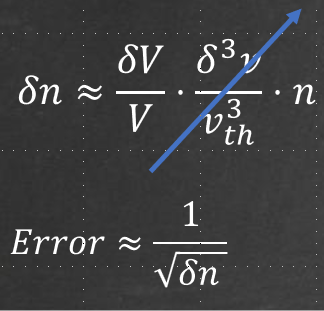

In [98]:
DLLn1 = ( (dx*dy)/(i_up) )*np.sum(cc[:,0:i_up])
DLLn2 = ( (dx*dy)/(i_dw-i_up) )*np.sum(cc[:,i_up:])

dln1 = 1/np.sqrt(DLLn1)
dln2 = 1/np.sqrt(DLLn2)

dln1, dln2

(0.03833299678973295, 0.02479278712813357)

In [99]:
Z = w_i.T*cc.T/(dx*R1*dy*R1)   #Usando transposta

n_massa = pd.DataFrame(Z,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
n_mass  = n_massa.T

n_mass = n_mass/1e6

In [100]:
n_mass

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,31.05,31.15,31.25,31.35,31.45,31.55,31.65,31.75,31.85,31.95
-4.95,21.337611,21.948397,21.698484,21.641855,21.673468,21.642401,21.594367,21.700890,21.753117,21.779272,...,49.500258,50.061936,48.248823,48.596469,48.279755,52.008880,54.024703,52.238083,51.205667,48.299150
-4.85,21.641153,22.336960,22.061640,21.874463,21.893322,21.896193,21.962850,21.886189,21.704155,21.730638,...,51.407755,51.157835,48.964457,46.828034,49.018823,47.288077,52.532659,49.929493,51.053581,51.343114
-4.75,21.573327,22.322406,22.020368,21.898333,21.879876,21.823801,21.906137,21.700783,21.745529,21.707781,...,53.518644,54.743635,50.243569,48.459231,52.610230,48.514440,51.114587,51.547543,52.849471,51.815536
-4.65,21.257346,21.764671,21.668770,21.600996,21.622353,21.576097,21.549887,21.782363,21.853877,21.867564,...,55.396320,53.824934,54.792463,50.208811,50.302175,55.228608,52.956887,49.004518,52.743024,47.267972
-4.55,21.415002,22.187167,22.005652,21.895377,21.911773,21.972993,21.933168,21.852197,21.784127,21.804104,...,53.561316,50.268807,47.685316,52.496812,49.737992,51.776443,51.916147,49.693321,49.847038,52.654316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,21.550219,22.228339,22.038228,21.962844,21.879585,21.901638,21.764748,21.825731,21.722138,21.631490,...,51.168721,50.797772,51.205572,50.196006,50.456210,52.867613,53.607182,55.139517,48.204113,49.907692
4.65,21.671447,22.226375,21.962231,21.806897,21.895300,21.872058,21.980510,21.949544,22.031752,21.824072,...,49.618988,47.801557,51.992716,47.984862,48.298456,50.794700,48.837946,49.970974,53.614387,51.229258
4.75,21.548886,22.235380,22.038671,21.957870,21.812222,21.797393,21.611016,21.529502,21.660515,21.572691,...,52.768275,53.494128,46.376242,48.389620,50.818893,49.374976,52.354534,48.377205,49.334527,53.246178
4.85,21.546596,22.082270,21.784011,21.588936,21.761677,21.726530,21.840773,21.754744,21.750808,21.842041,...,50.436871,47.930386,46.410570,48.672214,50.087458,54.090865,51.463505,51.824430,52.065155,51.221933


In [101]:
n_mass[n_mass.columns[0:40]]

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,21.337611,21.948397,21.698484,21.641855,21.673468,21.642401,21.594367,21.700890,21.753117,21.779272,...,21.569748,21.442924,21.526471,21.481570,21.394403,21.612253,21.589931,21.665276,21.741586,21.684794
-4.85,21.641153,22.336960,22.061640,21.874463,21.893322,21.896193,21.962850,21.886189,21.704155,21.730638,...,21.377722,21.584682,21.458151,21.472273,21.578553,21.447328,21.426356,21.495568,21.489905,21.776600
-4.75,21.573327,22.322406,22.020368,21.898333,21.879876,21.823801,21.906137,21.700783,21.745529,21.707781,...,21.710728,21.728801,21.780567,21.698703,21.823912,21.846285,21.774657,21.798690,21.639060,21.574062
-4.65,21.257346,21.764671,21.668770,21.600996,21.622353,21.576097,21.549887,21.782363,21.853877,21.867564,...,21.837627,21.711579,21.498128,21.531217,21.379298,21.381117,21.607293,21.462743,21.498760,21.420240
-4.55,21.415002,22.187167,22.005652,21.895377,21.911773,21.972993,21.933168,21.852197,21.784127,21.804104,...,21.574889,21.586926,21.569388,21.486258,21.425349,21.557267,21.615453,21.643250,21.739705,21.697687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,21.550219,22.228339,22.038228,21.962844,21.879585,21.901638,21.764748,21.825731,21.722138,21.631490,...,21.674425,21.694329,21.759180,21.710882,21.711611,21.477178,21.399130,21.486620,21.570001,21.663571
4.65,21.671447,22.226375,21.962231,21.806897,21.895300,21.872058,21.980510,21.949544,22.031752,21.824072,...,21.841956,21.653500,21.642859,21.593177,21.556766,21.538111,21.512980,21.354851,21.364350,21.288669
4.75,21.548886,22.235380,22.038671,21.957870,21.812222,21.797393,21.611016,21.529502,21.660515,21.572691,...,21.611363,21.541052,21.647612,21.616391,21.681356,21.661194,21.711243,21.705614,21.851272,21.849126
4.85,21.546596,22.082270,21.784011,21.588936,21.761677,21.726530,21.840773,21.754744,21.750808,21.842041,...,21.604338,21.674826,21.660331,21.604781,21.613237,21.523185,21.551111,21.467803,21.265934,21.164146


In [102]:
n_mass.describe()

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,31.05,31.15,31.25,31.35,31.45,31.55,31.65,31.75,31.85,31.95
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,21.438046,22.086380,21.861391,21.750707,21.751629,21.746911,21.748920,21.743299,21.743501,21.741016,...,51.252498,51.213747,51.054329,51.143821,50.323969,50.460573,50.674575,50.597691,50.555126,50.957103
std,0.163597,0.161252,0.128003,0.126171,0.136372,0.136602,0.127416,0.127362,0.121088,0.121578,...,2.287767,2.418310,2.331489,2.547667,2.251343,2.142136,2.264987,2.366488,1.953323,2.010552
min,21.017752,21.681517,21.544464,21.462046,21.471810,21.451792,21.489107,21.462317,21.493625,21.501452,...,45.930815,44.949166,46.376242,45.736888,45.719601,45.515667,46.017645,45.636040,46.459642,47.267972
25%,21.336587,21.973286,21.767063,21.657519,21.645238,21.637484,21.659257,21.666948,21.664463,21.643162,...,49.666809,49.560304,49.339428,49.469127,48.890941,49.073219,49.012109,48.892161,49.054028,49.394338
50%,21.432654,22.084869,21.851623,21.746719,21.752945,21.741918,21.727741,21.747167,21.747031,21.743968,...,51.055930,51.121210,51.060473,50.942965,50.197695,50.347471,50.364504,50.407991,50.537815,51.008935
75%,21.554537,22.191554,21.962616,21.826172,21.851977,21.849360,21.835137,21.823539,21.817515,21.831580,...,52.607461,52.883065,52.460296,52.896630,51.462324,51.823401,51.980998,51.935435,51.899210,52.161991
max,21.855265,22.443916,22.198851,22.116964,22.150300,22.044884,22.107574,22.115422,22.072196,22.136456,...,59.560438,58.168215,56.568237,57.587301,56.185434,55.228608,57.794470,57.395774,55.893497,57.352286


In [103]:
#Número de partículas na região pré e pós choque.

np.sum(cc[:,0:i_up]), np.sum(cc[:,i_up:])

(2722165.0, 52059414.0)

In [104]:
d_up = np.mean(np.mean(n_mass[n_mass.columns[0:i_up]]))
d_dw = np.mean(np.mean(n_mass[n_mass.columns[i_up:]]))

d_up, d_dw

(21.688274312746106, 51.16468775495608)

In [122]:
nsig_up = n_mass[n_mass.columns[0:i_up]]*dln1   # dln1 é o erro percentual estimado para cada bin na região pré-choque
nsig_dw = n_mass[n_mass.columns[i_up:]] *dln2   # dln2 é o erro percentual estimado para cada bin na região pós-choque

In [123]:
nsig_up

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,0.817935,0.841348,0.831768,0.829597,0.830809,0.829618,0.827777,0.831860,0.833862,0.834865,...,0.826833,0.821972,0.825174,0.823453,0.820112,0.828462,0.827607,0.830495,0.833420,0.831243
-4.85,0.829570,0.856243,0.845689,0.838514,0.839237,0.839347,0.841902,0.838963,0.831985,0.833000,...,0.819472,0.827406,0.822555,0.823097,0.827171,0.822140,0.821336,0.823990,0.823772,0.834762
-4.75,0.826970,0.855685,0.844107,0.839429,0.838721,0.836572,0.839728,0.831856,0.833571,0.832124,...,0.832237,0.832930,0.834914,0.831776,0.836576,0.837434,0.834688,0.835609,0.829490,0.826998
-4.65,0.814858,0.834305,0.830629,0.828031,0.828850,0.827076,0.826072,0.834983,0.837725,0.838249,...,0.837102,0.832270,0.824088,0.825356,0.819533,0.819602,0.828272,0.822731,0.824112,0.821102
-4.55,0.820901,0.850501,0.843543,0.839315,0.839944,0.842291,0.840764,0.837660,0.835051,0.835817,...,0.827030,0.827492,0.826819,0.823633,0.821298,0.826355,0.828585,0.829651,0.833348,0.831737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,0.826084,0.852079,0.844791,0.841902,0.838710,0.839555,0.834308,0.836646,0.832675,0.829200,...,0.830846,0.831609,0.834095,0.832243,0.832271,0.823285,0.820293,0.823647,0.826843,0.830430
4.65,0.830732,0.852004,0.841878,0.835924,0.839312,0.838422,0.842579,0.841392,0.844543,0.836582,...,0.837268,0.830044,0.829636,0.827731,0.826335,0.825620,0.824657,0.818595,0.818960,0.816058
4.75,0.826033,0.852349,0.844808,0.841711,0.836128,0.835559,0.828415,0.825290,0.830312,0.826946,...,0.828428,0.825733,0.829818,0.828621,0.831111,0.830338,0.832257,0.832041,0.837625,0.837542
4.85,0.825946,0.846480,0.835046,0.827569,0.834190,0.832843,0.837222,0.833925,0.833774,0.837271,...,0.828159,0.830861,0.830305,0.828176,0.828500,0.825048,0.826119,0.822925,0.815187,0.811285


In [124]:
nsig_dw

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,...,31.05,31.15,31.25,31.35,31.45,31.55,31.65,31.75,31.85,31.95
-4.95,0.535579,0.540153,0.544147,0.541773,0.558740,0.558561,0.567750,0.600118,0.620602,0.650559,...,1.227249,1.241175,1.196223,1.204842,1.196990,1.289445,1.339423,1.295128,1.269531,1.197471
-4.85,0.539685,0.542404,0.543916,0.547893,0.553634,0.564822,0.572561,0.586908,0.632450,0.666472,...,1.274542,1.268345,1.213965,1.160997,1.215313,1.172403,1.302431,1.237891,1.265761,1.272939
-4.75,0.535508,0.531611,0.540773,0.545434,0.560993,0.585728,0.587273,0.608759,0.629785,0.692713,...,1.326876,1.357247,1.245678,1.201439,1.304354,1.202808,1.267273,1.278007,1.310286,1.284652
-4.65,0.530531,0.534004,0.537372,0.537491,0.543947,0.567141,0.584021,0.604035,0.624568,0.670837,...,1.373429,1.334470,1.358458,1.244816,1.247131,1.369271,1.312949,1.214959,1.307647,1.171905
-4.55,0.540666,0.537610,0.545293,0.547348,0.558122,0.569079,0.583816,0.602899,0.625123,0.680895,...,1.327934,1.246304,1.182252,1.301542,1.233143,1.283682,1.287146,1.232036,1.235847,1.305447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,0.537094,0.536085,0.538767,0.544244,0.559022,0.559784,0.575104,0.596633,0.627271,0.655429,...,1.268615,1.259418,1.269529,1.244499,1.250950,1.310735,1.329071,1.367062,1.195114,1.237351
4.65,0.531058,0.531968,0.538158,0.547075,0.548948,0.567982,0.586294,0.611430,0.640218,0.684348,...,1.230193,1.185134,1.289044,1.189678,1.197453,1.259342,1.210829,1.238920,1.329250,1.270116
4.75,0.538126,0.539022,0.540436,0.543348,0.549194,0.550782,0.577587,0.596516,0.624031,0.685797,...,1.308273,1.326269,1.149796,1.199714,1.259942,1.224143,1.298015,1.199406,1.223140,1.320121
4.85,0.527718,0.532280,0.539395,0.540857,0.557618,0.556849,0.571324,0.602942,0.609028,0.651127,...,1.250471,1.188328,1.150647,1.206720,1.241808,1.341063,1.275924,1.284872,1.290840,1.269934


In [127]:
np.sum(np.abs(nsig_up))

-3.95    82.178454
-3.85    84.663714
-3.75    83.801263
-3.65    83.376979
-3.55    83.380514
-3.45    83.362427
-3.35    83.370127
-3.25    83.348582
-3.15    83.349356
-3.05    83.339828
-2.95    83.309947
-2.85    83.310332
-2.75    83.290373
-2.65    83.309941
-2.55    83.281531
-2.45    83.244184
-2.35    83.229374
-2.25    83.190318
-2.15    83.237971
-2.05    83.163085
-1.95    83.178460
-1.85    83.129726
-1.75    83.104643
-1.65    83.119587
-1.55    83.083670
-1.45    83.058358
-1.35    83.038854
-1.25    82.992816
-1.15    82.985472
-1.05    82.927232
-0.95    82.918988
-0.85    82.933163
-0.75    82.885521
-0.65    82.850918
-0.55    82.802570
-0.45    82.794492
-0.35    82.792675
-0.25    82.721943
-0.15    82.741325
-0.05    82.707486
dtype: float64

In [129]:
np.sum(np.sum(np.abs(nsig_up))), i_up*cc.shape[0]   #Soma dos erros de cada bin na região pré-choque, número de bins na região pré-choque.

(3325.506198421377, 4000)

In [130]:
err_up = np.sum(np.sum(np.abs(nsig_up)))/(i_up*cc.shape[0])         # Propagação do erro pré-choque para o calculo de uma média
err_dw = np.sum(np.sum(np.abs(nsig_dw)))/((i_dw-i_up)*cc.shape[0])  # Propagação do erro pós-choque

err_up, err_dw

(0.8313765496053442, 1.268515211986048)

In [131]:
display(Markdown(rf'$n_1: {d_up:5.4}  \pm {err_up:1.3} $'))

$n_1: 21.69  \pm 0.831 $

In [132]:
display(Markdown(rf'$n_2: {d_dw:6.5}  \pm {err_dw:1.3} $'))

$n_2: 51.165  \pm 1.27 $

#### Incerteza na densidade

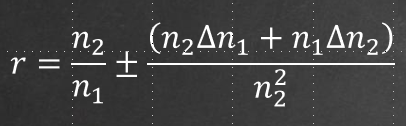

In [154]:
(d_dw*err_up+d_up*err_dw)/((d_dw)**2)

0.026758480856461566

In [150]:
d_up

21.688274312746106

In [149]:
err_up

0.8313765496053442

In [148]:
d_dw

51.16468775495608

In [155]:
deln = (d_dw*err_up+d_up*err_dw)/((d_dw)**2)
deln

0.026758480856461566

#### Incerteza na velocidade 

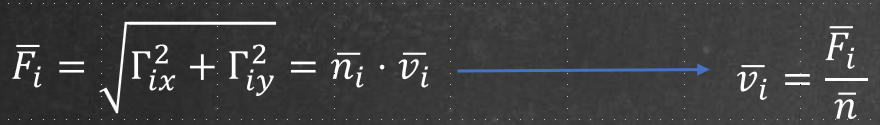

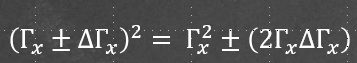

#### Cálculo dos fluxos médios

In [134]:
Fx_up = np.mean(np.mean(Fx[Fx.columns[0:i_up]]))
Fx_dw = np.mean(np.mean(Fx[Fx.columns[i_up:]]))

Fy_up = np.mean(np.mean(Fy[Fy.columns[0:i_up]]))
Fy_dw = np.mean(np.mean(Fy[Fy.columns[i_up:]]))

Fx_up, Fx_dw, Fy_up, Fy_dw

(-0.7890142534590829, 0.5723813974886698, 89.95892083110002, 89.5785551555254)

#### Estimativa das incerteza dos fluxos médios 

In [113]:
nfx_up = Fx[Fx.columns[0:i_up]]*dln1
nfx_dw = Fx[Fx.columns[i_up:]] *dln2

nfy_up = Fy[Fy.columns[0:i_up]]*dln1
nfy_dw = Fy[Fy.columns[i_up:]] *dln2

In [135]:
errfx_up = np.sum(np.sum(np.abs(nfx_up)))/(i_up*cc.shape[0])
errfx_dw = np.sum(np.sum(np.abs(nfx_dw)))/((i_dw-i_up)*cc.shape[0])

errfy_up = np.sum(np.sum(np.abs(nfy_up)))/(i_up*cc.shape[0])
errfy_dw = np.sum(np.sum(np.abs(nfy_dw)))/((i_dw-i_up)*cc.shape[0])

errfx_up, errfx_dw, errfy_up, errfy_dw

(0.010274205143233333, 0.1605006086173272, 1.00753991330832, 2.311126723012555)

#### Região pré-choque 

In [136]:
f_upx = Fx_up**2  
f_upy = Fy_up**2

delf_upx =  np.abs(2*Fx_up*errfx_up)
delf_upy =  np.abs(2*Fy_up*errfy_up)

#f_upx,f_upy, delf_upx, delf_upy

f_up    = (f_upx + f_upy)
delf_up = (delf_upx + delf_upy)

F_up    = np.sqrt(f_up)
Delf_up = 0.5*(1/(np.sqrt(f_up)))*delf_up

round(F_up,3), round(Delf_up,3)      # Fluxo médio na região pré-choque mais a incerteza

(89.962, 1.008)

####  Região pós-choque

In [137]:
f_dwx = Fx_dw**2  
f_dwy = Fy_dw**2

delf_dwx =  np.abs(2*Fx_dw*errfx_dw)
delf_dwy =  np.abs(2*Fy_dw*errfy_dw)

#f_upx,f_upy, delf_upx, delf_upy

f_dw    = (f_dwx + f_dwy)
delf_dw = (delf_dwx + delf_dwy)

F_dw    = np.sqrt(f_dw)
Delf_dw = 0.5*(1/(np.sqrt(f_dw)))*delf_dw

round(F_dw,3), round(Delf_dw,3)      # Fluxo médio na região pré-choque mais a incerteza

(89.58, 2.312)

#### Incerteza nas velocidades

In [138]:
v_up    = F_up/d_up
v_dw    = F_dw/d_dw

Del_vup = (F_up*err_up+d_up*Delf_up)/d_up**2
Del_vdw = (F_dw*err_dw+d_dw*Delf_dw)/d_dw**2

round(v_up*1e5,3), round(Del_vup*1e5,3), round(v_dw*1e5,3), round(Del_vdw*1e5,3)

(414797.321, 20546.213, 175082.44, 8859.729)

#### Estimativa do r a partir das velocidades

In [139]:
r_v    = v_up/v_dw
del_rv = (v_up*Del_vdw + v_dw*Del_vup)/v_dw**2

round(r_v, 3), round(del_rv, 3)

(2.369, 0.237)

In [140]:
v_up

4.14797321453923

In [141]:
round(v_up*1e2,3)

414.797

<IPython.core.display.Javascript object>


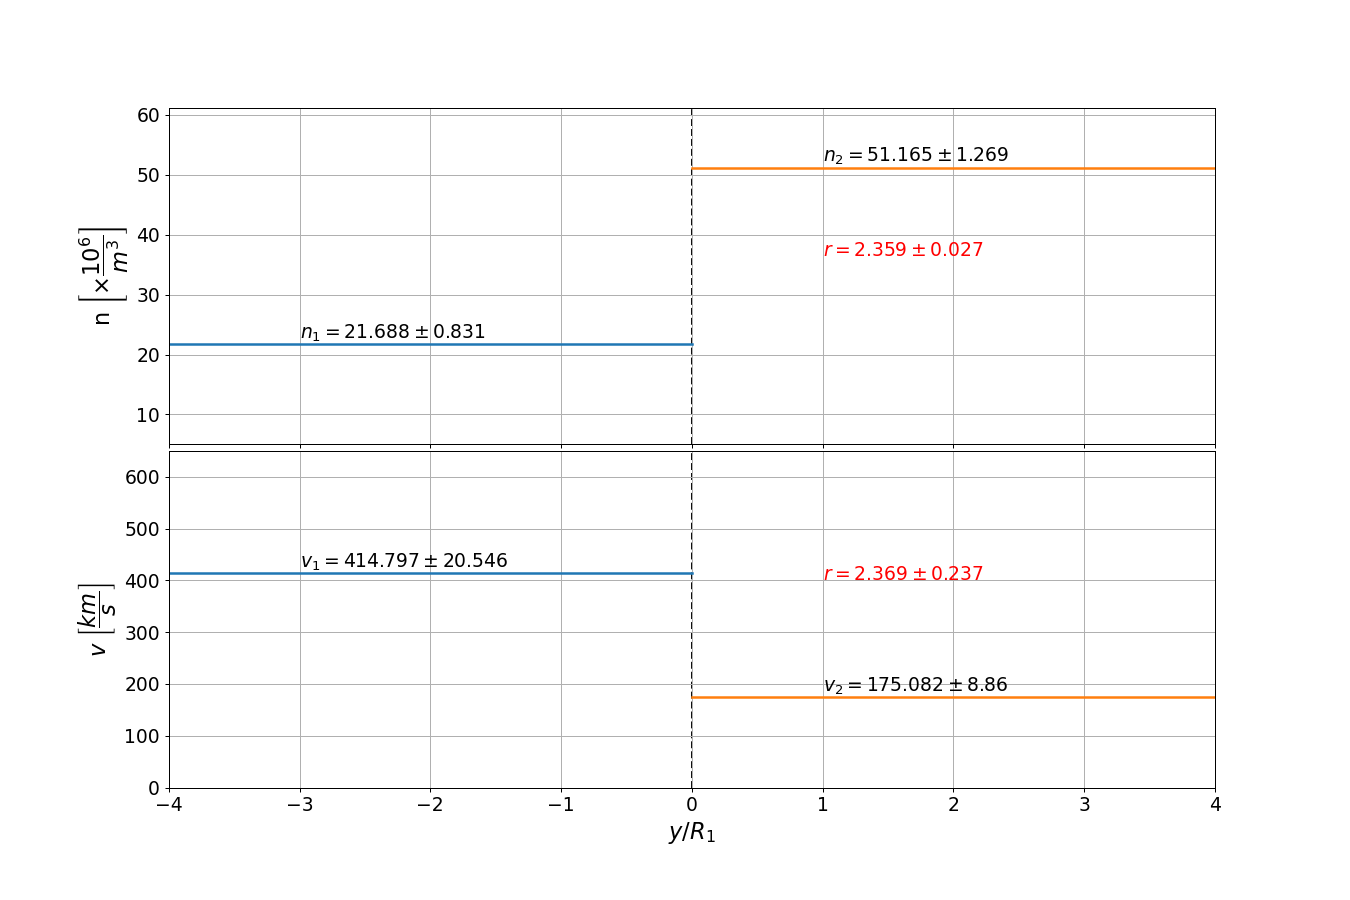

In [142]:
fig,ax = plt.subplots(2,gridspec_kw={'hspace': 0.02},figsize=(15,10))

n_1 = np.linspace(d_up, d_up, 50)
n_2 = np.linspace(d_dw, d_dw, 50)

v_1 = np.linspace(v_up*1e2, v_up*1e2, 50)
v_2 = np.linspace(v_dw*1e2, v_dw*1e2, 50)

xx_1 = np.linspace(-4,0, 50)
xx_2 = np.linspace(0,4, 50)

#Gráfico de densidade

ax[0].annotate(f'$n_1 = {round(d_up,3)} \pm {round(err_up,3)}$',    xy= (-3,d_up+1), size=15)  
ax[0].annotate(f'$n_2 = {round(d_dw,3)} \pm {round(err_dw,3)}$',    xy= (1,d_dw+1), size=15)  
ax[0].annotate(f'$r   = {np.round(d_dw/d_up,3)} \pm {round(deln,3)}$',    xy= (1,(d_up+d_dw)/2), size=15, color='red') 

ax[0].set_ylabel(r'n $\left[\times \dfrac{10^6}{m^3} \right]$', size=18)
ax[0].plot(xx_1, n_1, lw=2)
ax[0].plot(xx_2, n_2, lw=2)
ax[0].axvline(0, ls = '--', c = 'k', zorder=1)
ax[0].grid(axis='both')
ax[0].set_ylim([5,d_dw+10])
ax[0].set_xlim([-4,4])
ax[0].set_xticks(np.arange(-4,4.1))

ax[0].tick_params(axis='both',labelsize=15)    
ax[0].label_outer()
#ax[0].set_aspect(1)

#Gráfico da velocidade

ax[1].annotate(f'$v_1 = {round(v_up*1e2,3)} \pm {round(Del_vup*1e2,3)}$',    xy= (-3,v_up*1e2+10), size=15)  
ax[1].annotate(f'$v_2 = {round(v_dw*1e2,3)} \pm {round(Del_vdw*1e2,3)}$',    xy= (1,v_dw*1e2+10), size=15)  
ax[1].annotate(f'$r   = {np.round(v_up/v_dw,3)} \pm {round(del_rv,3)}$',    xy= (1,400), size=15, color='red') 


ax[1].set_ylabel(r'$v$ '+ r'$ \left[\dfrac{km}{s} \right]$', size=18)
ax[1].set_xlabel(r'$y/R_1$', size=18)
ax[1].plot(xx_1, v_1, lw=2)
ax[1].plot(xx_2, v_2, lw=2)
ax[1].axvline(0, ls = '--', c = 'k', zorder=1)
ax[1].grid(axis='both')
ax[1].set_ylim([0,650]);
ax[1].set_xlim([-4,4])
ax[1].set_xticks(np.arange(-4,4.1))

ax[1].tick_params(axis='both',labelsize=15)  
#ax[1].set_aspect(1)

#plt.savefig(path_in+'boris2D\\Parametrosfisicos_50000_particles_01.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

### Cálculo da densidade média, em x/R1, ao longo de y/R1 

In [143]:
nerror_up = np.array(nsig_up.sum()/100)
nerror_dw = np.array(nsig_dw.sum()/100)

In [144]:
n_error = np.concatenate((nerror_dw,nerror_up)) # Juntos os dois vetores contendo os erros das medidas de densidade
#n_error

In [145]:
n_m = n_mass.describe().loc['mean']
n_M = np.array(n_m)
n_m

-3.95     21.438046
-3.85     22.086380
-3.75     21.861391
-3.65     21.750707
-3.55     21.751629
            ...    
 31.55    50.460573
 31.65    50.674575
 31.75    50.597691
 31.85    50.555126
 31.95    50.957103
Name: mean, Length: 360, dtype: float64

In [146]:
max(n_M)+5

101.45530779604434

<IPython.core.display.Javascript object>


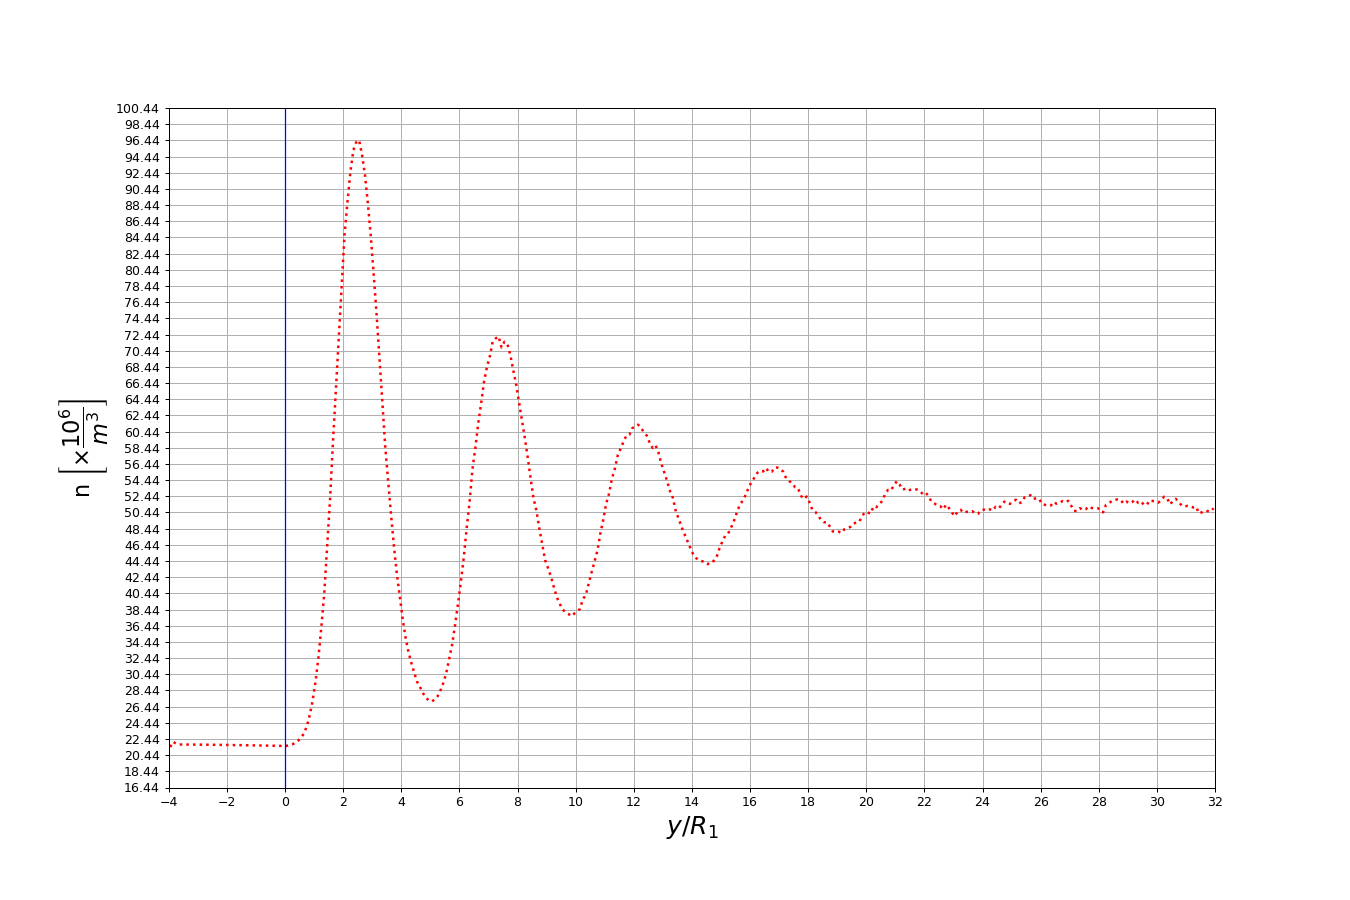

In [147]:
y_d = np.arange(y_1+dy/2,y_2,dy) 

fig,ax = plt.subplots(gridspec_kw={'hspace': 0.02},figsize=(15,10))

ax.plot(y_d, n_M, lw=2, ls=':', color='r')
ax.axvline(0 , color='b',lw=1)
#ax.scatter(y_d[78],n_M[78], lw=10, s=1)

ax.set_xlim([-4,32])
ax.set_xticks(np.arange(-4,32.1,2))
ax.set_yticks(np.arange(min(n_M)-5,max(n_M)+5,2))

ax.set_xlabel(r'$y/R_1$',size= 20)
ax.set_ylabel(r'n $\left[\times \dfrac{10^6}{m^3} \right]$', size=18, color='black')


ax.grid()

## Gráficos adicionais 

In [171]:
x0lower = -5.0
x0upper = 5.0 

x0 = 0.0
y0 = -4.0*R1 
z0 = 0.0

y_p = 5.1526656924467975

In [174]:
rx.shape

(1401, 50000)

In [178]:
rx[:,0].shape

(1401,)

<IPython.core.display.Javascript object>


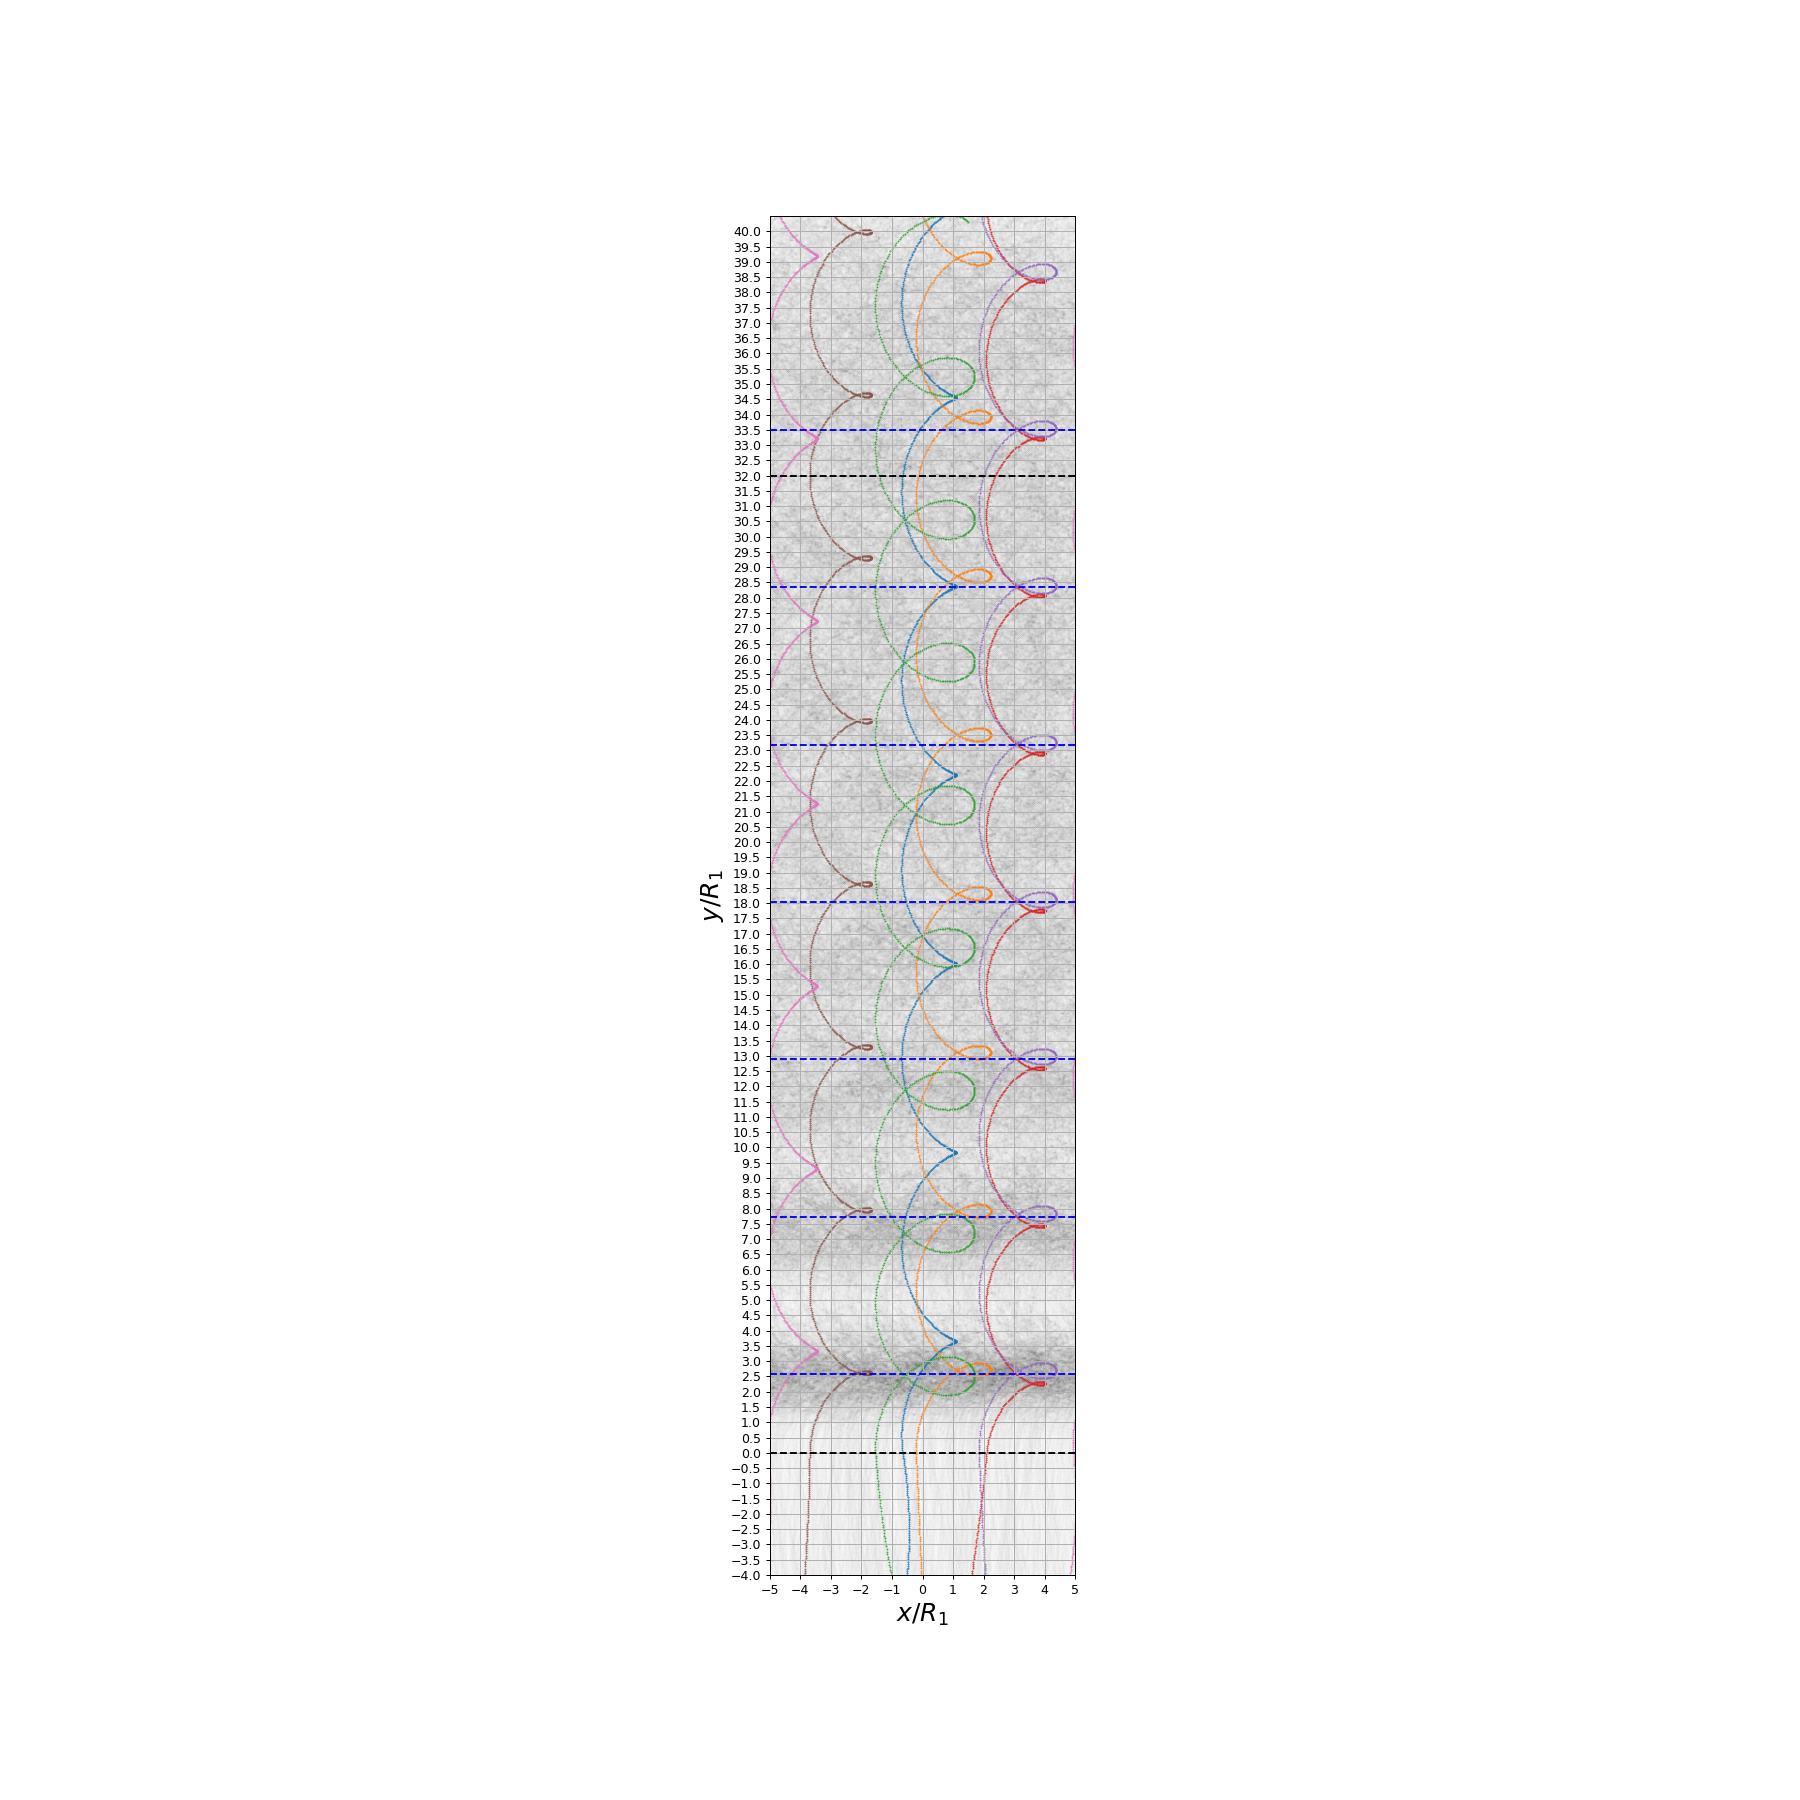

In [182]:
fig,ax = plt.subplots(1,1,figsize=(20,20))

# Plot da densidade de pontos
ax.scatter(rx[:ynlim,0:50000:20]/R1,ry[:ynlim,0:50000:20]/R1,s=0.00002, color='k')

#Trajetórias específicas 
#ax.scatter(rx[:,0]/R1  , ry[:,0]/R1,s=0.5,marker='.', color='r')

#ax.scatter(rx[:,700]/R1, ry[:,700]/R1,s=0.5,marker='.', color='g')


for i in range(0,7):
    
    ax.axhline(y= (1/2+i)*y_p, color='blue', linestyle='--')
    ax.scatter(rx[:,200*i]/R1  , ry[:,200*i]/R1,s= 1 ,marker='.')

ax.axhline(y=0.0, color='k', linestyle='--')
ax.axhline(y=32., color='k', linestyle='--')

ax.set_ylim([-4,40.5]); 
ax.set_xlim([-5,5])

ax.set_xticks(np.arange(-5,5.1,1))

ax.set_yticks(np.arange(-4,40.1,0.5))

ax.set_xlabel(r'$x/R_1$',size=20);ax.set_ylabel(r'$y/R_1$',size= 20)
ax.grid(axis='both')

ax.set_aspect(1)

<IPython.core.display.Javascript object>


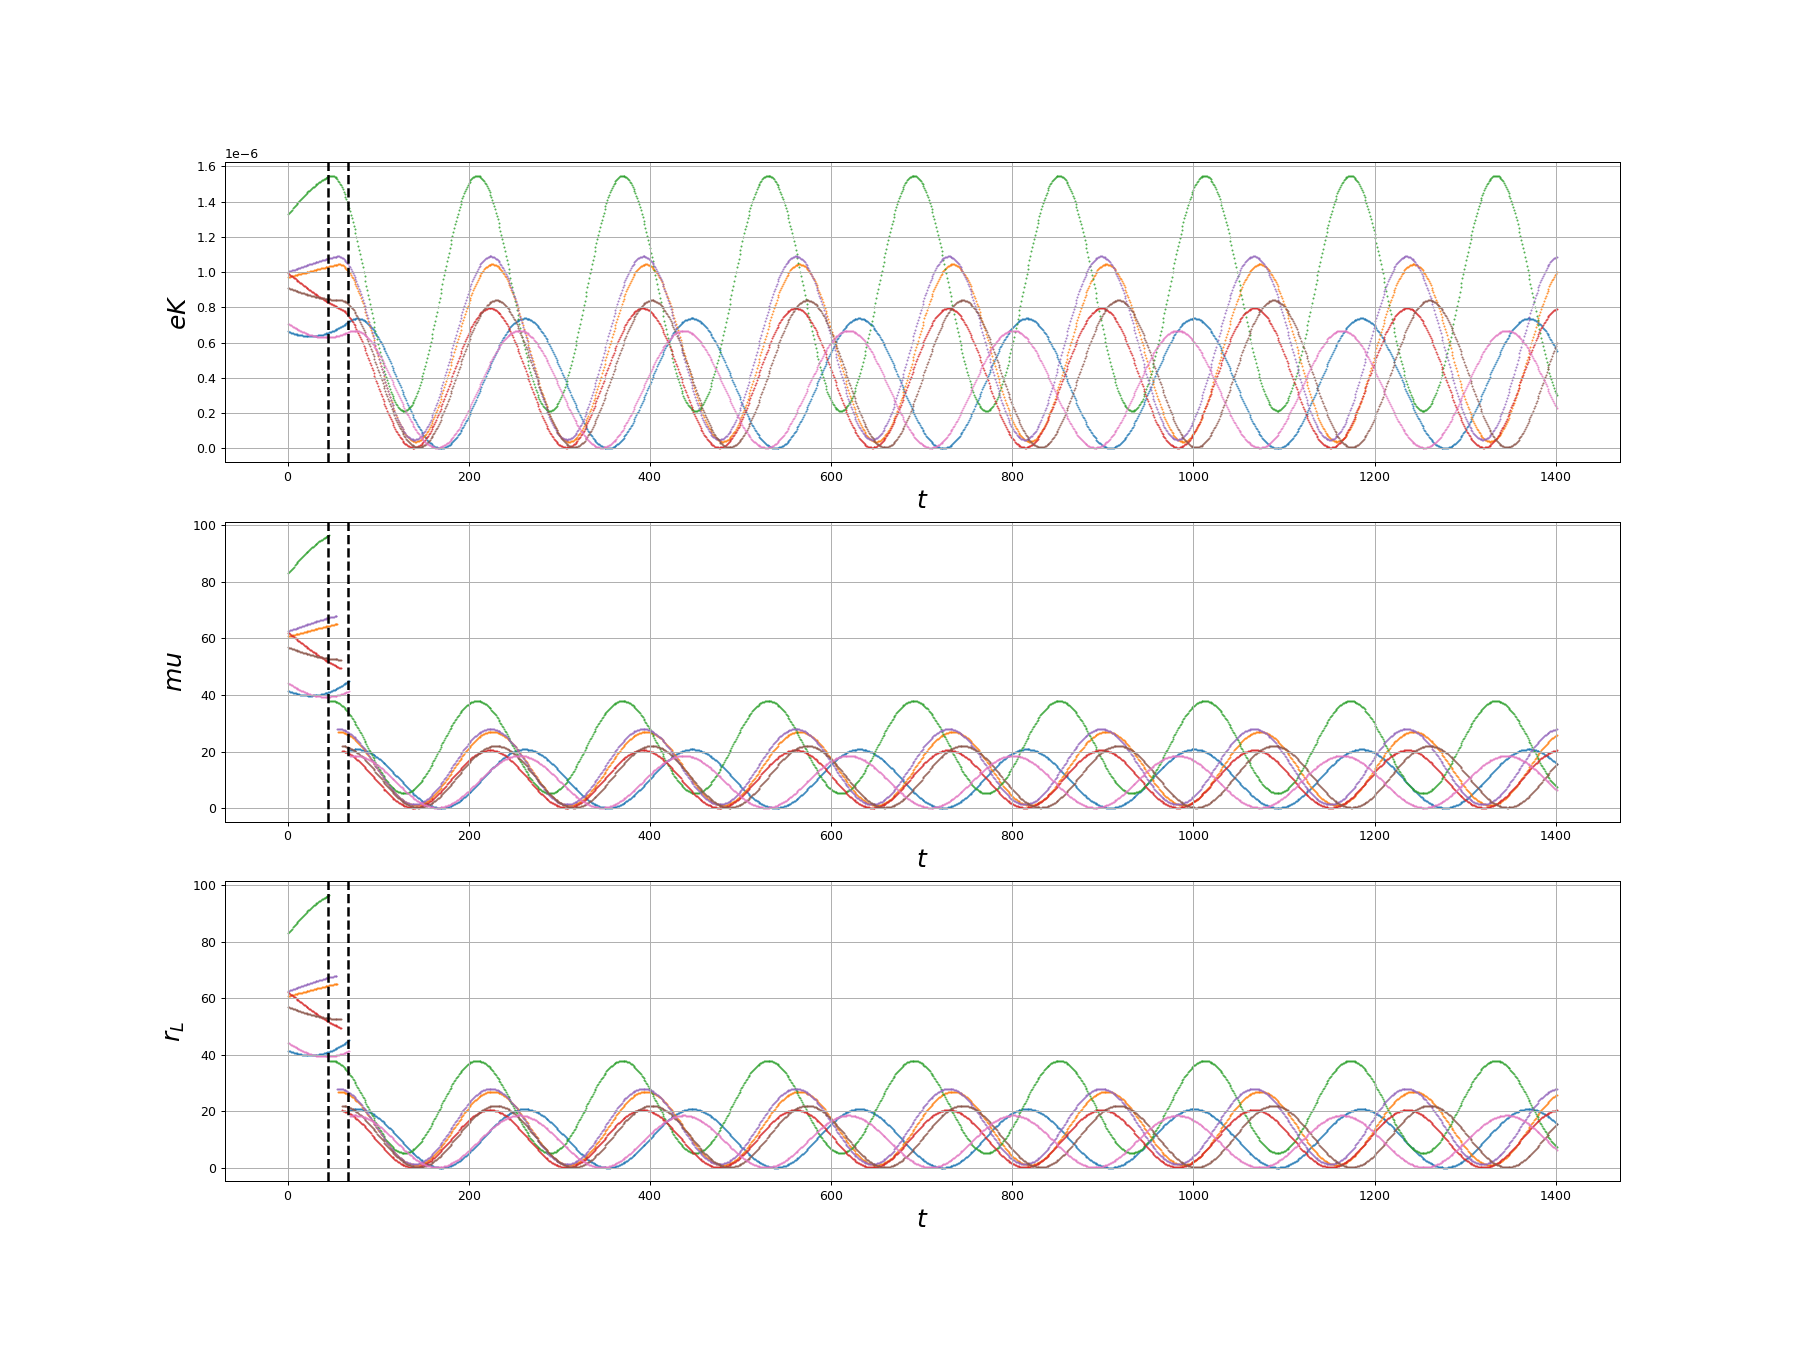

In [198]:
fig,ax = plt.subplots(3,gridspec_kw={'hspace': 0.2},figsize=(20,15))
    
for i in range(0,7):
    
    ax[0].scatter(np.arange(1,ek.shape[0]+1), ek[:,200*i], s= 1 ,marker='.')
    ax[1].scatter(np.arange(1,mu.shape[0]+1),mu[:,200*i], s= 1 ,marker='.')
    ax[2].scatter(np.arange(1,rL.shape[0]+1),rL[:,200*i], s= 1 ,marker='.')
    
it1 = np.abs(ry[:,400]).argmin()
it2 = np.abs(ry[:,1200]).argmin()

ax[0].set_ylabel(r'$eK$', size=20)
ax[1].set_ylabel(r'$mu$', size=20)
ax[2].set_ylabel(r'$r_L$', size=20)

for i in range(0,3):
    ax[i].axvline(x = it1, color='k', linestyle='--',lw=2, zorder=10)
    ax[i].axvline(x = it2, color='k', linestyle='--',lw=2, zorder=10)
    
    ax[i].set_xlabel(r'$t$', size=20);
    ax[i].grid(axis='both')
    

plt.show()